# ARIMA 探究 #

## a.    数据预处理 ##
### 导入包 ###

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
import numpy as np

### 格式转换 ###
将数据格式转换为 索引为Datetime的Pandas.Series，否则无法进行ADF校验

In [2]:
origin_data = pd.read_csv('AirPassengers.csv')

data = origin_data.set_index(keys='Month', drop=True)
data.rename(columns={'#Passengers':'Passengers'}, inplace=True)

data.index = pd.to_datetime(data.index)
data = data.Passengers

### 对数化 ###
由于原数据值域范围比较大，为了缩小值域，同时保留其他信息，常用的方法是对数化，取log

In [3]:
data_log = np.log(data)

# fitted_data = np.exp(fitted_data_log)    # 逆向操作

## b.    平稳性验证（ADF校验） ##
对整体数据进行ADF校验

In [4]:
import statsmodels.tsa.stattools
adf_result = statsmodels.tsa.stattools.adfuller(data_log)    # 对乘客数做ADF校验

#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
adf_output = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adf_result[4].items():
    adf_output['Critical Value (%s)'%key] = value
print(adf_output)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### 使用seansonal包之前，要先进行index的格式转换，通过to_datetime(df.index)将索引转换为datetime ###

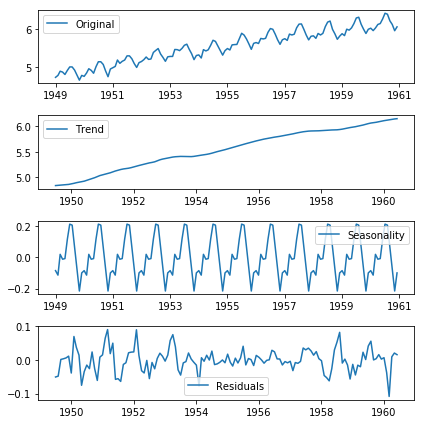

In [5]:
# http://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
import statsmodels.tsa.seasonal
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(data_log, model='additive')    
# 模型分为additive（相加）, multiplicative（相乘），可以都试一下看效果
# additive: The additive model is Y[t] = T[t] + S[t] + e[t]
# multiplicative: The multiplicative model is Y[t] = T[t] * S[t] * e[t]

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(data_log, label='Original')
ax1.legend(loc='best')

ax2.plot(trend, label='Trend')
ax2.legend(loc='best')

ax3.plot(seasonal,label='Seasonality')
ax3.legend(loc='best')

ax4.plot(residual, label='Residuals')
ax4.legend(loc='best')

plt.tight_layout()    # 调节绘图空间使图像比较自然

### 滑动平均校验稳定性 ###

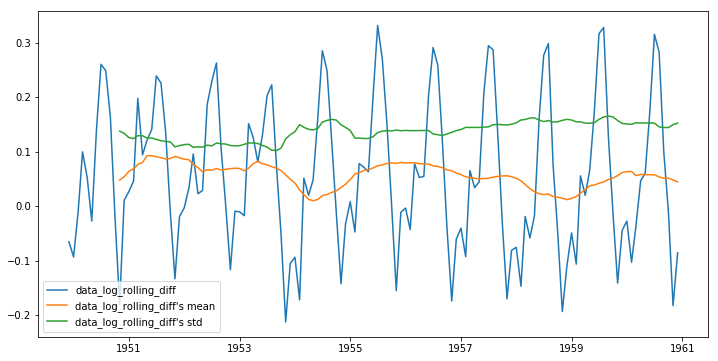

In [6]:
# 注：pandas新版本中将rolling_mean等方法统一为df.rolling()方法，并调用mean()求滑动的平均值进行替代
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html
data_log_rolling_mean = data_log.rolling(window=12).mean()
data_log_rolling_mean_diff = data_log - data_log_rolling_mean
data_log_rolling_mean_diff.dropna(inplace = True)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ax.plot(data_log_rolling_mean_diff)
ax.plot(data_log_rolling_mean_diff.rolling(window=12).mean())
ax.plot(data_log_rolling_mean_diff.rolling(window=12).std())

ax.legend(['data_log_rolling_diff', 'data_log_rolling_diff\'s mean', 'data_log_rolling_diff\'s std'])

### 指数平均校验稳定性 ###

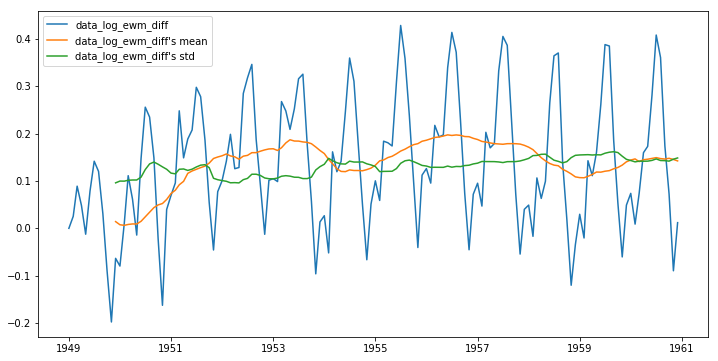

In [7]:
# 注：pandas新版本中将ewma(Exponentially Weighted Moving-Average 指数平均)等方法统一为df.ewm()方法，并调用mean()求指数滑动的平均值进行替代
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ewm.html
data_log_ewm_mean = data_log.ewm(halflife=12).mean()
data_log_ewm_mean_diff = data_log - data_log_ewm_mean
data_log_ewm_mean_diff.dropna(inplace = True)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ax.plot(data_log_ewm_mean_diff)
ax.plot(data_log_ewm_mean_diff.rolling(window=12).mean())
ax.plot(data_log_ewm_mean_diff.rolling(window=12).std())

ax.legend(['data_log_ewm_diff', 'data_log_ewm_diff\'s mean', 'data_log_ewm_diff\'s std'])

### 差分校验稳定性 ###

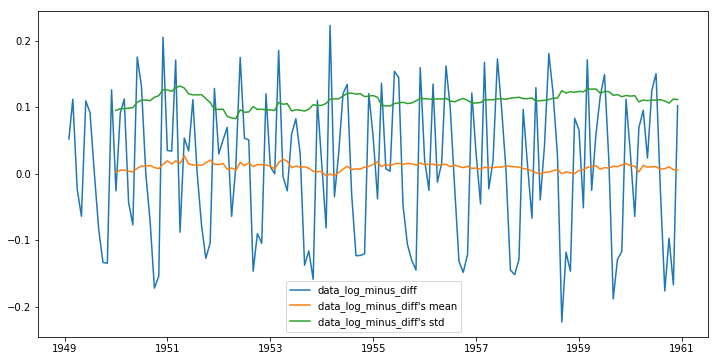

In [8]:
# 注：pandas新版本中使用df.diff求差分（参数periods为阶数），替代data - data.shift()操作
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html
data_log_minus_diff =  data_log.diff(periods=1)
data_log_minus_diff.dropna(inplace=True)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ax.plot(data_log_minus_diff)
ax.plot(data_log_minus_diff.rolling(window=12).mean())
ax.plot(data_log_minus_diff.rolling(window=12).std())

ax.legend(['data_log_minus_diff', 'data_log_minus_diff\'s mean', 'data_log_minus_diff\'s std'])

### 对一阶差值做ADF校验 ###

In [9]:
import statsmodels.tsa.stattools
adf_result = statsmodels.tsa.stattools.adfuller(data_log.diff(1).dropna())    # 对一阶差值做ADF校验

#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test of DIFF(2):')
adf_output = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adf_result[4].items():
    adf_output['Critical Value (%s)'%key] = value
print(adf_output)

Results of Dickey-Fuller Test of DIFF(2):
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


## c.    非白噪声验证（Ljung-Box检验） ##
Ljung-Box检验：假设检验：原假设目标数列为高斯白噪声，当p值>5%或10%认为接受该检验，否则拒绝该检验，目标数列存在时序相关关系

In [10]:
import statsmodels.stats.diagnostic
lb, pvalue = statsmodels.stats.diagnostic.acorr_ljungbox(data_log.diff(1).dropna(), lags=24)
print(lb,pvalue)

[  5.82633006   7.94763097  11.31443324  26.78839178  27.84793849
  27.94851496  29.82568606  47.24021982  49.30756034  51.16892181
  57.82535037 169.89001676 177.26887496 180.39926573 182.57887318
 195.28258855 195.72255862 195.74830407 197.93512081 217.10008849
 219.05997362 220.02933047 226.90477114 321.52817956] [1.57880263e-02 1.88015590e-02 1.01416352e-02 2.19362327e-05
 3.89765328e-05 9.60838109e-05 1.02210721e-04 1.37986745e-07
 1.45337128e-07 1.62544610e-07 2.34371782e-08 5.02776791e-30
 6.11831355e-31 5.37315623e-31 7.17460387e-31 7.11008651e-33
 2.07020327e-32 7.08325284e-32 8.76134244e-32 4.52297774e-35
 6.19380833e-35 1.30900984e-34 1.86220858e-35 7.56028399e-54]


## d. 画ACF, PACF图确定参数 ##
注：二阶差分不是diff(2)而是diff(1).diff(1)！，diff(2)是Yt3 - Yt1

D:\Continuum\anaconda3\envs\data\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


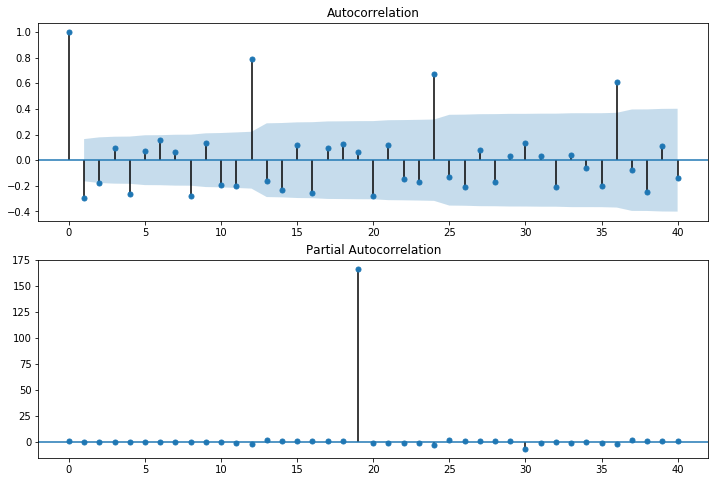

In [11]:
import statsmodels.graphics.tsaplots
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(data_log.diff(1).diff(1).dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(data_log.diff(1).diff(1).dropna(),lags=40,ax=ax2)

### 还可采用建立多模型，通过比较AIC BIC HIC，全部最小的为最佳模型的方法 ###
https://blog.csdn.net/u010414589/article/details/49622625  <br />
https://blog.csdn.net/hal_sakai/article/details/51965657

In [12]:
'''
arma_mod20 = sm.tsa.ARMA(dta,(7,0)).fit()
print(arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic)
arma_mod30 = sm.tsa.ARMA(dta,(0,1)).fit()
print(arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic)
arma_mod40 = sm.tsa.ARMA(dta,(7,1)).fit()
print(arma_mod40.aic,arma_mod40.bic,arma_mod40.hqic)
arma_mod50 = sm.tsa.ARMA(dta,(8,0)).fit()
print(arma_mod50.aic,arma_mod50.bic,arma_mod50.hqic)
'''

'\narma_mod20 = sm.tsa.ARMA(dta,(7,0)).fit()\nprint(arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic)\narma_mod30 = sm.tsa.ARMA(dta,(0,1)).fit()\nprint(arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic)\narma_mod40 = sm.tsa.ARMA(dta,(7,1)).fit()\nprint(arma_mod40.aic,arma_mod40.bic,arma_mod40.hqic)\narma_mod50 = sm.tsa.ARMA(dta,(8,0)).fit()\nprint(arma_mod50.aic,arma_mod50.bic,arma_mod50.hqic)\n'

## e. 建模并拟合 ##

D:\Continuum\anaconda3\envs\data\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Continuum\anaconda3\envs\data\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'RSS: 0.3025')

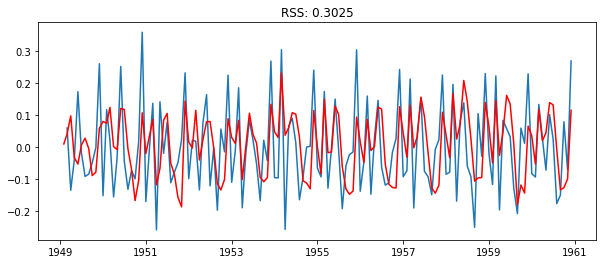

In [13]:
import statsmodels.tsa.arima_model

# https://blog.csdn.net/wangqi_qiangku/article/details/79384731
arima_model = statsmodels.tsa.arima_model.ARMA(data_log.diff(1).dropna(),(11,2), freq='MS').fit()

# 二阶
# arima_model = statsmodels.tsa.arima_model.ARMA(data_log.diff(1).diff(1).dropna(),(8,1), freq='MS').fit()

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)

ax.plot(data_log.diff(1).diff(1))
ax.plot(arima_model.fittedvalues, color='red')

rss = sum((arima_model.fittedvalues-data_log.diff(1).dropna()).dropna()**2)

# 二阶
# rss = sum((arima_model.fittedvalues-data_log.diff(1).diff(1).dropna()).dropna()**2)

ax.set_title('RSS: %.4f'% rss)

## f.    模型检验 ##
主要针对模型拟合后的残差 arima_model.resid做检验，满足ACF+PACF、Ljung-Box、独立性、QQ图等

In [14]:
resid = arima_model.resid

'''
注：
拟合出arma模型的参数：arima_model.arparams(ar), arima_model.maparams(ma)，给定阶数arima_model.k_ar, arima_model.k_ma
model.predict() 返回的值就是 fittedvalues
'''

'\n注：\n拟合出arma模型的参数：arima_model.arparams(ar), arima_model.maparams(ma)，给定阶数arima_model.k_ar, arima_model.k_ma\nmodel.predict() 返回的值就是 fittedvalues\n'

### ACF, PACF图 ###
观察连续残差是否（自）相关

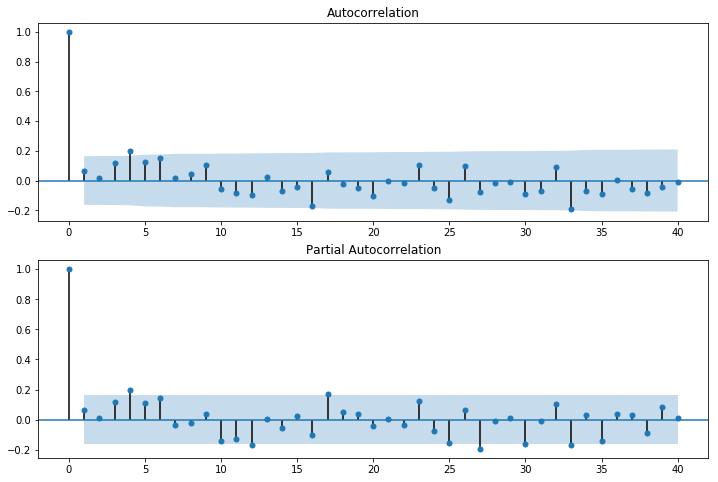

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(resid, lags=40, ax=ax2)

### D-W检验 ###
德宾-沃森（Durbin-Watson）检验，简称D-W检验，是目前检验自相关性最常用的方法，但它只使用于检验一阶自相关性。因为自相关系数ρ的值介于-1和1之间，所以 0 ≤ DW ≤ ４。并且DW＝0＝＞ρ＝１ 即存在正自相关性 
DW＝４＜＝＞ρ＝－１　即存在负自相关性 
DW＝２＜＝＞ρ＝0　　即不存在（一阶）自相关性 
因此，当DW值显著的接近于0或４时，则存在自相关性，而接近于２时，则不存在（一阶）自相关性。这样只要知道DW统计量的概率分布，在给定的显著水平下，根据临界值的位置就可以对原假设H0进行检验

In [16]:
import statsmodels.stats.stattools
print(statsmodels.stats.stattools.durbin_watson(resid.values))

1.8589377328929662


### QQ图 ###
用于直观验证一组数据是否来自某个分布（此处使用正态分布），或者验证某两组数据是否来自同一（族）分布

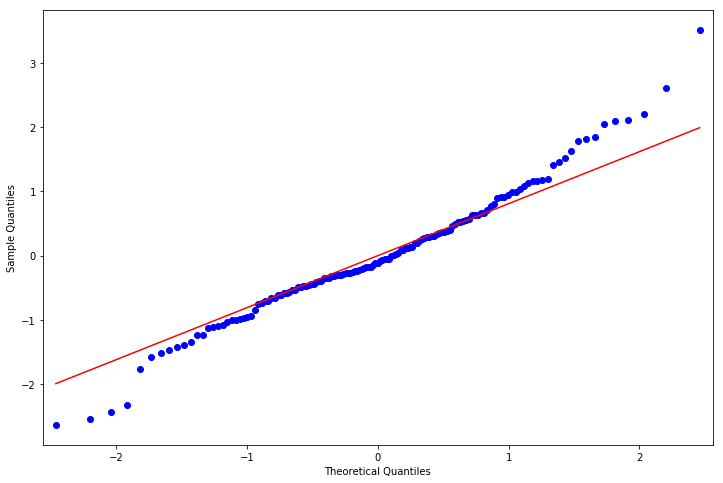

In [17]:
import statsmodels.graphics.gofplots
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = statsmodels.graphics.gofplots.qqplot(resid, line='q', ax=ax, fit=True)

### Ljung-Box检验 ###
Ljung-Box test是对randomness的检验,或者说是对时间序列是否存在滞后相关的一种统计检验。
对于滞后相关的检验，我们常常采用的方法还包括计算ACF和PCAF并观察其图像，但是无论是ACF还是PACF都仅仅考虑是否存在某一特定滞后阶数的相关。LB检验则是基于一系列滞后阶数，判断序列总体的相关性或者说随机性是否存在。 
时间序列中一个最基本的模型就是高斯白噪声序列。而对于ARIMA模型，其残差被假定为高斯白噪声序列，所以当我们用ARIMA模型去拟合数据时，拟合后我们要对残差的估计序列进行LB检验，判断其是否是高斯白噪声，如果不是，那么就说明ARIMA模型也许并不是一个适合样本的模型。

In [18]:
import statsmodels.stats.diagnostic
lb, pvalue = statsmodels.stats.diagnostic.acorr_ljungbox(resid, lags=40)
test_data = np.c_[range(1,41), lb, pvalue]
table = pd.DataFrame(test_data, columns=['lag', "Q", "Prob(>Q)"])
print(table.set_index('lag'))

'''
两段代码作用相同
r,q,p = statsmodels.tsa.stattools.acf(resid.values.squeeze(), qstat=True)
test_data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(test_data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))
'''

              Q  Prob(>Q)
lag                      
1.0    0.659046  0.416897
2.0    0.704782  0.703005
3.0    2.791907  0.424834
4.0    8.827401  0.065561
5.0   11.071265  0.049985
6.0   14.694235  0.022773
7.0   14.726380  0.039671
8.0   14.982039  0.059496
9.0   16.730386  0.053109
10.0  17.179844  0.070478
11.0  18.290470  0.075081
12.0  19.792305  0.071118
13.0  19.876431  0.098335
14.0  20.691422  0.109806
15.0  20.960592  0.138093
16.0  25.684017  0.058640
17.0  26.239735  0.070202
18.0  26.339852  0.092237
19.0  26.744869  0.110738
20.0  28.515104  0.097755
21.0  28.517172  0.126084
22.0  28.551287  0.158123
23.0  30.533312  0.134696
24.0  30.983015  0.154273
25.0  34.148289  0.104776
26.0  35.825498  0.094925
27.0  36.827155  0.098339
28.0  36.874967  0.121644
29.0  36.892048  0.149006
30.0  38.384685  0.140121
31.0  39.234264  0.147234
32.0  40.735780  0.138375
33.0  47.484749  0.049158
34.0  48.451078  0.051513
35.0  50.016535  0.047942
36.0  50.016906  0.060283
37.0  50.724

'\n两段代码作用相同\nr,q,p = statsmodels.tsa.stattools.acf(resid.values.squeeze(), qstat=True)\ntest_data = np.c_[range(1,41), r[1:], q, p]\ntable = pd.DataFrame(test_data, columns=[\'lag\', "AC", "Q", "Prob(>Q)"])\nprint(table.set_index(\'lag\'))\n'

## g.    模型预测 ##

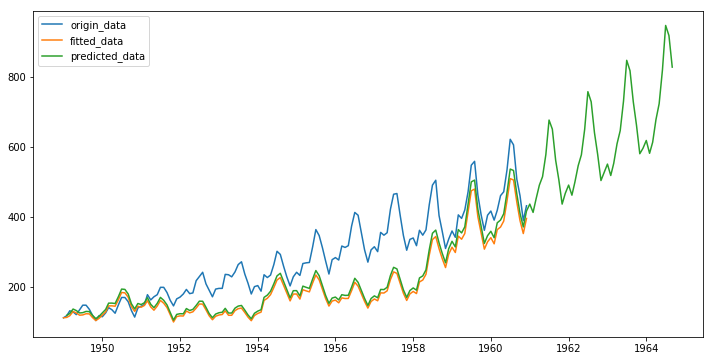

In [19]:
# 一阶还原
def reverse_order_1(arima_model, data_log):
    fitted_values = arima_model.fittedvalues
    data_log_origin = data_log
    data_log_diff_1_first = pd.Series(data=data_log_origin[0], index=data_log_origin.index)
    data_log_diff_1_fitted = data_log_diff_1_first.add(fitted_values.cumsum(), fill_value=0)
    data_fitted = np.exp(data_log_diff_1_fitted)
    return data_fitted


# 一阶预测 + 还原
def reverse_order_1_predict(arima_model, start_date, end_date, data_log):
    fitted_values = arima_model.predict(start_date, end_date)
    data_log_origin = data_log
    
    # 生成start_date - end_date的索引，MS=month start
    # http://pandas.pydata.org/pandas-docs/stable/generated/pandas.date_range.html
    data_log_diff_1_first = pd.Series(data=data_log_origin[start_date], index=pd.date_range(start=start_date, end=end_date, freq='MS'))
    
    data_log_diff_1_fitted = data_log_diff_1_first.add(fitted_values.cumsum(), fill_value=0)
    data_fitted = np.exp(data_log_diff_1_fitted)
    return data_fitted


# 二阶还原
def reverse_order_2(arima_model, data_log):
    fitted_values = arima_model.fittedvalues
    data_log_origin = data_log
    data_log_diff_2_first = pd.Series(data=data_log_origin.diff(1).dropna()[0], index=data_log_origin.diff(1).dropna().index)
    data_log_diff_2_fitted = data_log_diff_2_first.add(fitted_values.cumsum(), fill_value=0)
    
    # 与原数据比较，验证还原准确性
    # data_log_diff_2_fitted_compare = data_log_diff_2_first.add(data_log.diff(1).diff(1).cumsum(), fill_value=0)%%!

    data_log_diff_1_first = pd.Series(data=data_log_origin[0], index=data_log_origin.index)
    data_log_diff_1_fitted = data_log_diff_1_first.add(data_log_diff_2_fitted.cumsum(), fill_value=0)
    
    # 与原数据比较，验证还原准确性
    # data_log_diff_1_fitted_compare = data_log_diff_1_first.add(data_log_diff_2_fitted_compare.cumsum(), fill_value=0)
    
    data_fitted = np.exp(data_log_diff_1_fitted)
    return data_fitted

reversed_fittedvalue = reverse_order_1(arima_model, data_log)
reversed_predictedvalue = reverse_order_1_predict(arima_model, '1949-02-01', '1964-09-01', data_log)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(data)
ax.plot(reversed_fittedvalue)
ax.plot(reversed_predictedvalue)
ax.legend(['origin_data', 'fitted_data', 'predicted_data'])

# rss = np.sqrt(sum((data_fitted-data)**2)/len(data))
# ax.set_title('RSS: %.4f' % rss)